Імпорт бібліотек

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Завантаження CIFAR-10

In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

Вибір двох класів

In [21]:
class_1, class_2 = 2, 4
train_mask = np.isin(y_train, [class_1, class_2]).flatten()
test_mask = np.isin(y_test, [class_1, class_2]).flatten()

x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

Обмеження кількості даних до 500 зображень

In [22]:
x_train = x_train[:500]
y_train = y_train[:500]
x_test = x_test[:500]
y_test = y_test[:500]


Перекодування міток на 0 та 1

In [23]:
y_train = (y_train == class_2).astype(np.int32).flatten()
y_test = (y_test == class_2).astype(np.int32).flatten()


Масштабування зображень

In [24]:
IMG_SIZE = 224
x_train = tf.image.resize(x_train, (IMG_SIZE, IMG_SIZE)) / 255.0
x_test = tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE)) / 255.0

Завантаження моделі MobileNetV2 без TensorFlow Hub

In [25]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,  # Без верхнього шару
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling='avg',  # Середнє зважене обчислення для кожного каналу
    weights='imagenet'  # Попередньо навчена модель
)

Адаптація моделі за допомогою Functional API

In [26]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))  # Вхідний шар
x = base_model(inputs, training=False)  # Проходимо через базову модель, без тренування
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Додаємо шар для класифікації
model = tf.keras.Model(inputs=inputs, outputs=x)  # Створюємо модель

Компіляція та тренування моделі

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(x_train, y_train, validation_split=0.2, epochs=5)

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7207 - loss: 0.5776 - val_accuracy: 0.5700 - val_loss: 3.1100
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8921 - loss: 0.2520 - val_accuracy: 0.5300 - val_loss: 14.7217
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9485 - loss: 0.1489 - val_accuracy: 0.5300 - val_loss: 2.1474
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9800 - loss: 0.0656 - val_accuracy: 0.5300 - val_loss: 6.4763
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9945 - loss: 0.0348 - val_accuracy: 0.5600 - val_loss: 3.2732


Розморожуємо частину шарів

In [28]:
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(x_train, y_train, validation_split=0.2, epochs=5)


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9814 - loss: 0.0424 - val_accuracy: 0.5300 - val_loss: 3.8744
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 0.5700 - val_loss: 2.7328
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.5900 - val_loss: 1.4167
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.6300 - val_loss: 1.3436
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6500 - val_loss: 1.5055


Оцінка моделі

In [29]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Точність моделі: {accuracy:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - accuracy: 0.6837 - loss: 1.0566
Точність моделі: 0.68


Матриця похибок

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step


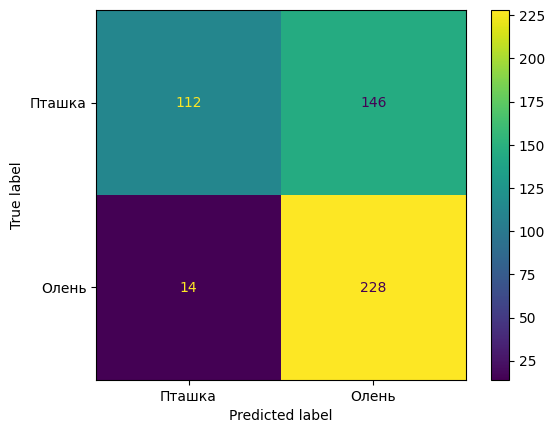

In [32]:
y_pred = (model.predict(x_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Пташка", "Олень"])
disp.plot()
plt.show()

Візуалізація результатів

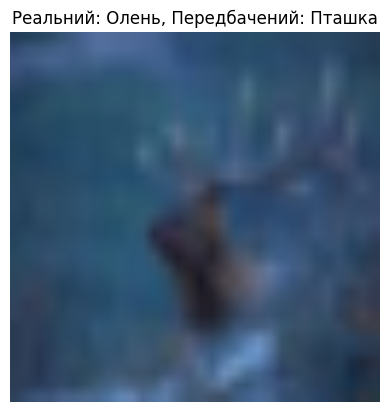

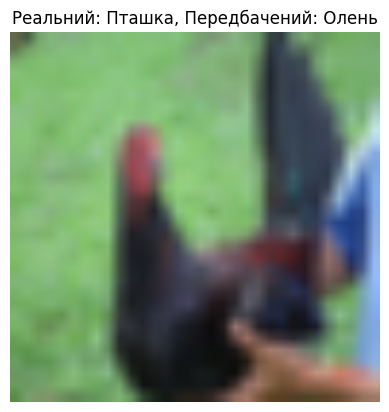

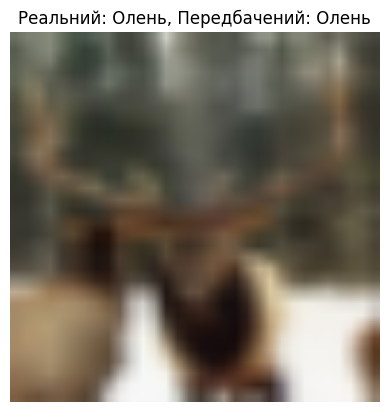

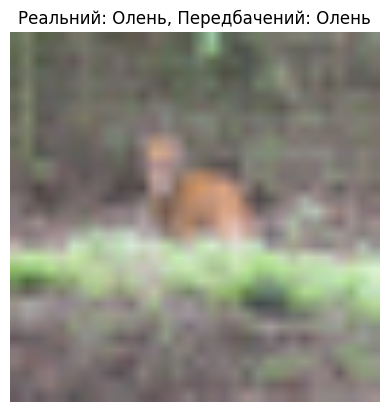

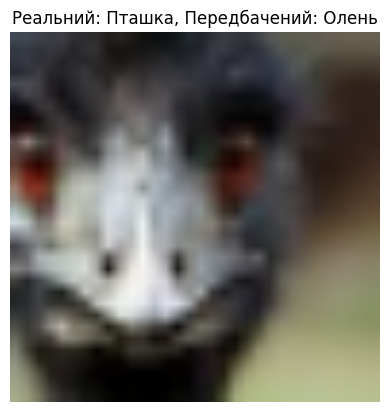

In [33]:
for i in range(5):
    plt.imshow(x_test[i])
    plt.title(f"Реальний: {'Олень' if y_test[i] else 'Пташка'}, Передбачений: {'Олень' if y_pred[i] else 'Пташка'}")
    plt.axis('off')
    plt.show()